# FRB 220207aabh: spectrum model needs more components

In [4]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, sgram_fn, gauss_norm, gauss_norm3
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

#from burstfit.utils.functions import gauss_norm2, pulse_fn_vec, sgram_fn_vec 
%matplotlib inline 


# input variables 
candidate = '220207aabh'
datestring = '2022_2_6_19_34_4'
beam = 136
corr = 'corr09'
dm_heimdall = 263
width_heimdall = 2 
snr_heimdall = 60 
mask_chans=[] 

#fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
fil_file = '/home/ubuntu/vikram/scratch/220207aabh.fil'
save_name = candidate + '_beam_'+str(beam)
save_dir = '/home/ubuntu/gechen/burstfit_tests_outputs/' 


#data = ff.proc_cand_fil(fil_file, dm, width, nfreq_plot=64, ndm=64)[0]
#data_t = data.mean(0)

logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)
# create burst object 
bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
)

bd.prepare_data()


# number of channels after binning 
# requires each channel bin to have SNR_min 
# snr_heimdall was calculated with all 256 channels binned into one 
SNR_min = 3 
n_per_bin = int(256. / (1.0*snr_heimdall / SNR_min)**2) 
if n_per_bin <= 1:
    n_per_bin = 1
elif not math.log(n_per_bin, 2).is_integer():
    n_per_bin = 2 ** (int(np.log2(n_per_bin))+1)
    
nfreq = int(256 / n_per_bin) 
print(nfreq)


2022-04-04 23:23:28,311 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-04-04 23:23:30,184 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-04-04 23:23:30,187 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-04-04 23:23:30,190 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (masked, masked)


256


In [13]:
# read in data 
nfreq = 64 
data64 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
np.save('%s_%d.txt'%(candidate, nfreq), data64, allow_pickle=False)


In [6]:
# read in data 
nfreq = 8 
data8 = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
np.save('%s_%d.txt'%(candidate, nfreq), data8, allow_pickle=False)


Text(0.5,0,'binned channel')

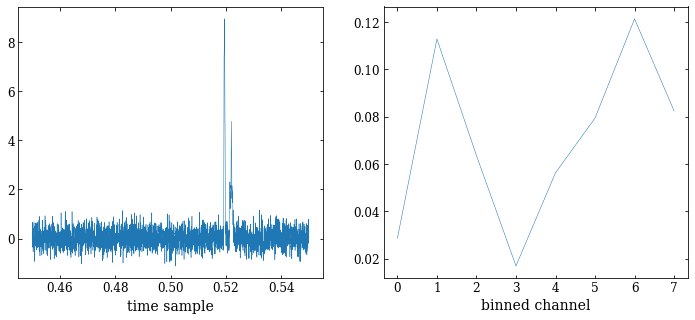

In [8]:
#data = np.load(candidate + '_' + str(nfreq) + '.txt.npy') 
data = data8
# i_low = int(0.5/bd.tsamp - 100*bd.width)
# i_high = int(0.5/bd.tsamp + 100*bd.width)

i_low = int(0.45/bd.tsamp)
i_high = int(0.55/bd.tsamp)

data_burst = data[:, i_low: i_high] # change to x * width 
t_burst = [i * bd.tsamp for i in range(i_low, i_high)]

fig1, ax1 = plt.subplots(1, 2) 
fig1.set_size_inches(12., 5.)
ax1[0].plot(t_burst, data_burst.mean(0))
ax1[0].set_xlabel('time sample')
ax1[1].plot(data_burst.mean(1))
ax1[1].set_xlabel('binned channel')

In [9]:
# fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
bf_S1T2 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print('bf.ncomponents=%d'%bf.ncomponents)
print(data_burst)

# Some setting up before we do the fitting 
bf_S1T2.validate()
bf_S1T2.precalc()



self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['mu', 'sig']
bf.ncomponents=0
[[-0.36797425  1.0709568   0.18015555 ... -0.159457    1.2633797
   1.2894416 ]
 [ 1.1399521   0.23994687  1.7409781  ...  2.1342506  -0.10502897
  -0.3066467 ]
 [ 0.6201884  -0.8034119  -0.37640548 ...  1.3124399   1.187485
  -0.75894684]
 [-0.20392205 -0.64702284  1.6980448  ...  1.1215533  -0.41090757
  -0.27214912]]


2022-03-31 23:44:57,434 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-03-31 23:44:57,515 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-03-31 23:44:57,517 - initial_profilefit -burstfit.fit - INFO - S: 21.64284998754395 +- 22.285600895273788
2022-03-31 23:44:57,519 - initial_profilefit -burstfit.fit - INFO - mu_t: 494.76705372510395 +- 6.894880990650877
2022-03-31 23:44:57,521 - initial_profilefit -burstfit.fit - INFO - sigma_t: 2.6053104700591736 +- 7.49181426402116
2022-03-31 23:44:57,523 - initial_profilefit -burstfit.fit - INFO - tau: 6.986371447751418 +- 17.797793246168037


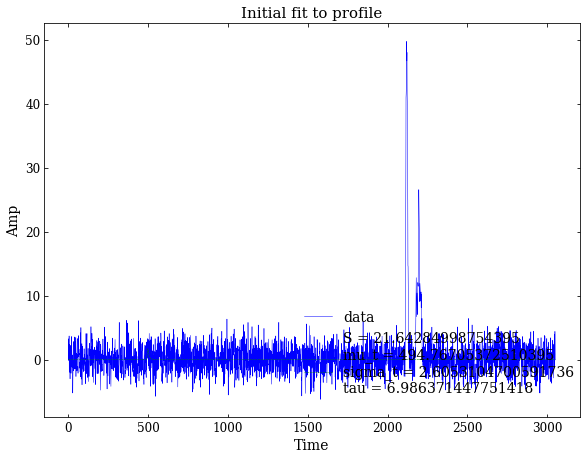

2022-03-31 23:44:57,737 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-03-31 23:44:57,739 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-03-31 23:44:57,788 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-03-31 23:44:57,790 - initial_profilefit -burstfit.fit - INFO - S: 0.35607359654995585 +- 23.68375836234166
2022-03-31 23:44:57,792 - initial_profilefit -burstfit.fit - INFO - mu_t: 1518.0000000016298 +- 614.408437728117
2022-03-31 23:44:57,795 - initial_profilefit -burstfit.fit - INFO - sigma_t: 7.9997588199795295 +- 614.4083702933094
2022-03-31 23:44:57,797 - initial_profilefit -burstfit.fit - INFO - tau: 0.1761275963033433 +- 0.0


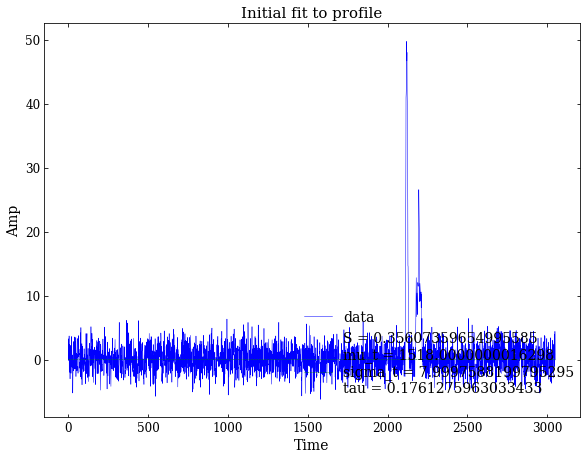

2022-03-31 23:44:58,014 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-03-31 23:44:58,016 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function gauss_norm at 0x7fa9b86710d0>
[-0.66403407 -0.25779328  1.7939628  -0.40830508]


2022-03-31 23:44:58,046 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-03-31 23:44:58,047 - initial_spectrafit -burstfit.fit - INFO - mu_f: 1.8659132152968094 +- 7762.161223626136
2022-03-31 23:44:58,048 - initial_spectrafit -burstfit.fit - INFO - sigma_f: 0.14512112573310862 +- 49025.82552811445


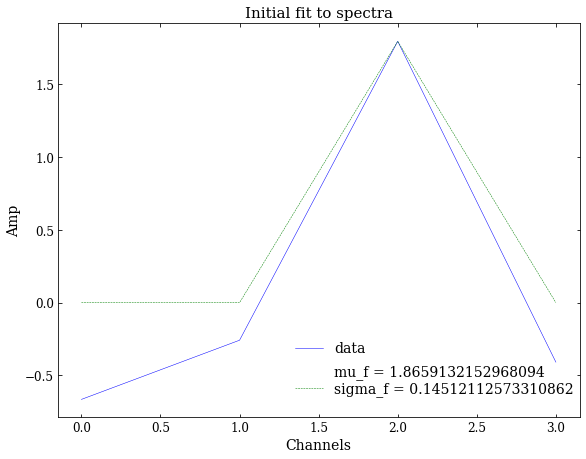

2022-03-31 23:44:58,189 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-03-31 23:44:58,190 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [1.8659132152968094, 0.14512112573310862, 0.35607359654995585, 1518.0000000016298, 7.9997588199795295, 0.1761275963033433, 263]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/functions.py:167: RuntimeWarning: overflow encountered in exp
  B = np.exp((1 / 2) * (sigma / tau) ** 2)
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/functions.py:172: RuntimeWarning: overflow encountered in exp
  pulse[scat_idx] = A * B * np.exp(ln_C) * D
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/burstfit-0.1.1-py3.6.egg/burstfit/utils/functions.py:172: RuntimeWarning: invalid value encountered in multiply
  pulse[scat_idx] = A * B * np.exp(ln_C) * D
/home/ubuntu/anaconda3/envs/casa/lib/python3.6

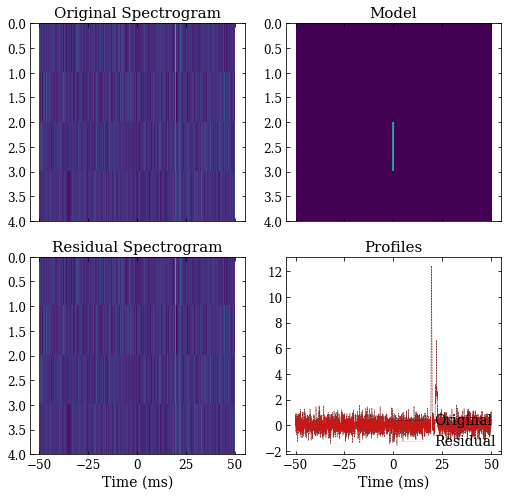

2022-03-31 23:44:59,770 - model -burstfit.fit - INFO - Making model.
2022-03-31 23:44:59,773 - model -burstfit.fit - INFO - Found 1 components.
2022-03-31 23:44:59,777 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-03-31 23:44:59,779 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-03-31 23:44:59,781 - model -burstfit.fit - INFO - Making model.
2022-03-31 23:44:59,783 - model -burstfit.fit - INFO - Found 1 components.
2022-03-31 23:44:59,787 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.8785089993247186


In [12]:
bounds_profile = ([-np.inf, 450, 0, 0], [np.inf, 550, 5 * bd.width, np.inf]) # ['S', 'mu_t', 'sigma_t', 'tau']
bf_S1T2.initial_profilefit(bounds = bounds_profile, plot = True)


bf.fitcycle(plot=True)
# # fit all componnts 
# bf.fitall(plot=True) 
# bf.calc_redchisq()
# plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
#                  bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
# #dm_fit, dm_fit_err = bf.sgram_params['all'][1]['popt'][-1], bf.sgram_params['all'][1]['perr'][-1]

In [2]:
# bf.sgram_params
# plot_me(bf.model[:,int(382/2-30): int(382/2+30)]) 
# bd.tsamp*3*1e3

# dm_diff = 103.46597098341815 - 103
# print('expected despersion in tsamp: %.1f time samples'%(4.149e3*dm_diff*(1/1280**2 - 1/1530**2) / bd.tsamp)) 

# plot_me(bf.model)

# bf.sgram_params

# sgramModel.nparams


In [3]:
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])


bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print(np.shape(data_burst))

# Some setting up before we do the fitting 
bf.validate()
bf.precalc()
print('bf.ncomponents=%d'%bf.ncomponents)


(256, 382)
bf.ncomponents=0


In [4]:
bf.fitcycle(plot=False)
print('bf.ncomponents=%d'%bf.ncomponents)

# fit all componnts 
bf.fitall(plot=False) 
print('bf.ncomponents=%d'%bf.ncomponents)

bf.sgram_params

2022-02-15 21:18:02,201 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-02-15 21:18:02,204 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-02-15 21:18:02,232 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-02-15 21:18:02,234 - initial_profilefit -burstfit.fit - INFO - S: 1652.378792578131 +- 70.29561242342375
2022-02-15 21:18:02,236 - initial_profilefit -burstfit.fit - INFO - mu_t: 190.27345000980904 +- 0.15086132454369558
2022-02-15 21:18:02,237 - initial_profilefit -burstfit.fit - INFO - sigma_t: 0.6238365150489971 +- 0.10693418838080178
2022-02-15 21:18:02,239 - initial_profilefit -burstfit.fit - INFO - tau: 0.35081351592107163 +- 0.20518130161081602
2022-02-15 21:18:02,241 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-02-15 21:18:02,243 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2022-02-15 21:18:02

bf.ncomponents=1


2022-02-15 21:18:04,780 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-02-15 21:18:04,782 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-02-15 21:18:04,788 - tests -root - INFO - P values: T-test (0.96453), Kruskal (0.64656), KS (0.86897), F-test (0.00356)
2022-02-15 21:18:04,790 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-02-15 21:18:04,797 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2022-02-15 21:18:04,799 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-02-15 21:18:04,807 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00000)
2022-02-15 21:18:04,809 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-02-15 21:18:04,812 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-02-15 21:18:04,837 - initial_profilefi

2022-02-15 21:18:42,303 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2022-02-15 21:18:42,306 - model -burstfit.fit - INFO - Making model.
2022-02-15 21:18:42,309 - model -burstfit.fit - INFO - Found 3 components.
2022-02-15 21:18:42,397 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0955258297414454
2022-02-15 21:18:42,400 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-02-15 21:18:42,402 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-02-15 21:18:42,407 - tests -root - INFO - P values: T-test (0.96453), Kruskal (0.64656), KS (0.86897), F-test (0.00356)
2022-02-15 21:18:42,409 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-02-15 21:18:42,415 - tests -root - INFO - P values: T-test (0.38906), Kruskal (0.00074), KS (0.00000), F-test (0.00205)
2022-02-15 21:18:42,417 - run_tests -burstfit.fit - INFO - Running on pulse - off p

bf.ncomponents=3


{1: {'popt': [134.78762428705036,
   65.2719925756224,
   1816.4340863270888,
   190.84330158126343,
   0.47293939202821933,
   0.3428061726869266,
   262.50294584557236],
  'perr': array([1.31734955e+00, 1.20959718e+00, 1.12815884e+01, 2.83527945e-02,
         6.90655625e-03, 5.62401299e-03, 1.47792163e-02])},
 2: {'popt': [131.02580708537099,
   79.10759787802768,
   1620.3849552038978,
   200.23624497942893,
   1.371256952110334,
   0.33336220763790736,
   262.4703697342776],
  'perr': array([2.98122732e+00, 2.76176727e+00, 2.23168138e+01, 1.15091846e-01,
         2.46573069e-02, 1.12347485e-02, 7.81206510e-02])},
 3: {'popt': [50.31856409554866,
   1.5443465514870083,
   20.88247276363975,
   178.67435166038752,
   5.081838676068091,
   0.5474481908581845,
   260.47601813693683],
  'perr': array([  1.06504832,   0.94422332,   5.27477263,  52.19688132,
           2.05775357,   0.        , 117.165522  ])},
 'all': {1: {'popt': [134.7895473543776,
    65.2726931580013,
    1816.448866

2022-02-15 21:18:42,452 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-02-15 21:18:42,454 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [1.34789547e+02 6.52726932e+01 1.81644887e+03 1.90808014e+02
 4.72699467e-01 3.43011334e-01 2.62514141e+02 1.31025800e+02
 7.91076014e+01 1.62038322e+03 2.00239979e+02 1.36940890e+00
 3.33162990e-01 2.62472671e+02 5.03185214e+01 1.54434184e+00
 2.08824751e+01 1.78674210e+02 5.08180955e+00 5.47448191e-01
 2.60475986e+02]
2022-02-15 21:18:42,457 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-02-15 21:18:42,460 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-02-15 21:18:42,462 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-02-15 21:18:42,464 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(0.98

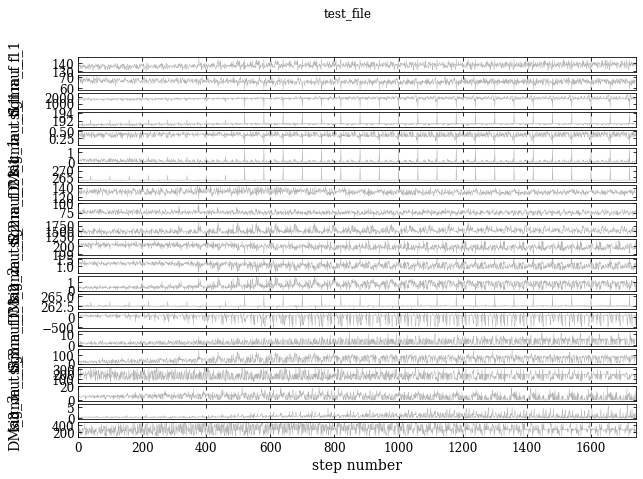

<Figure size 432x288 with 0 Axes>

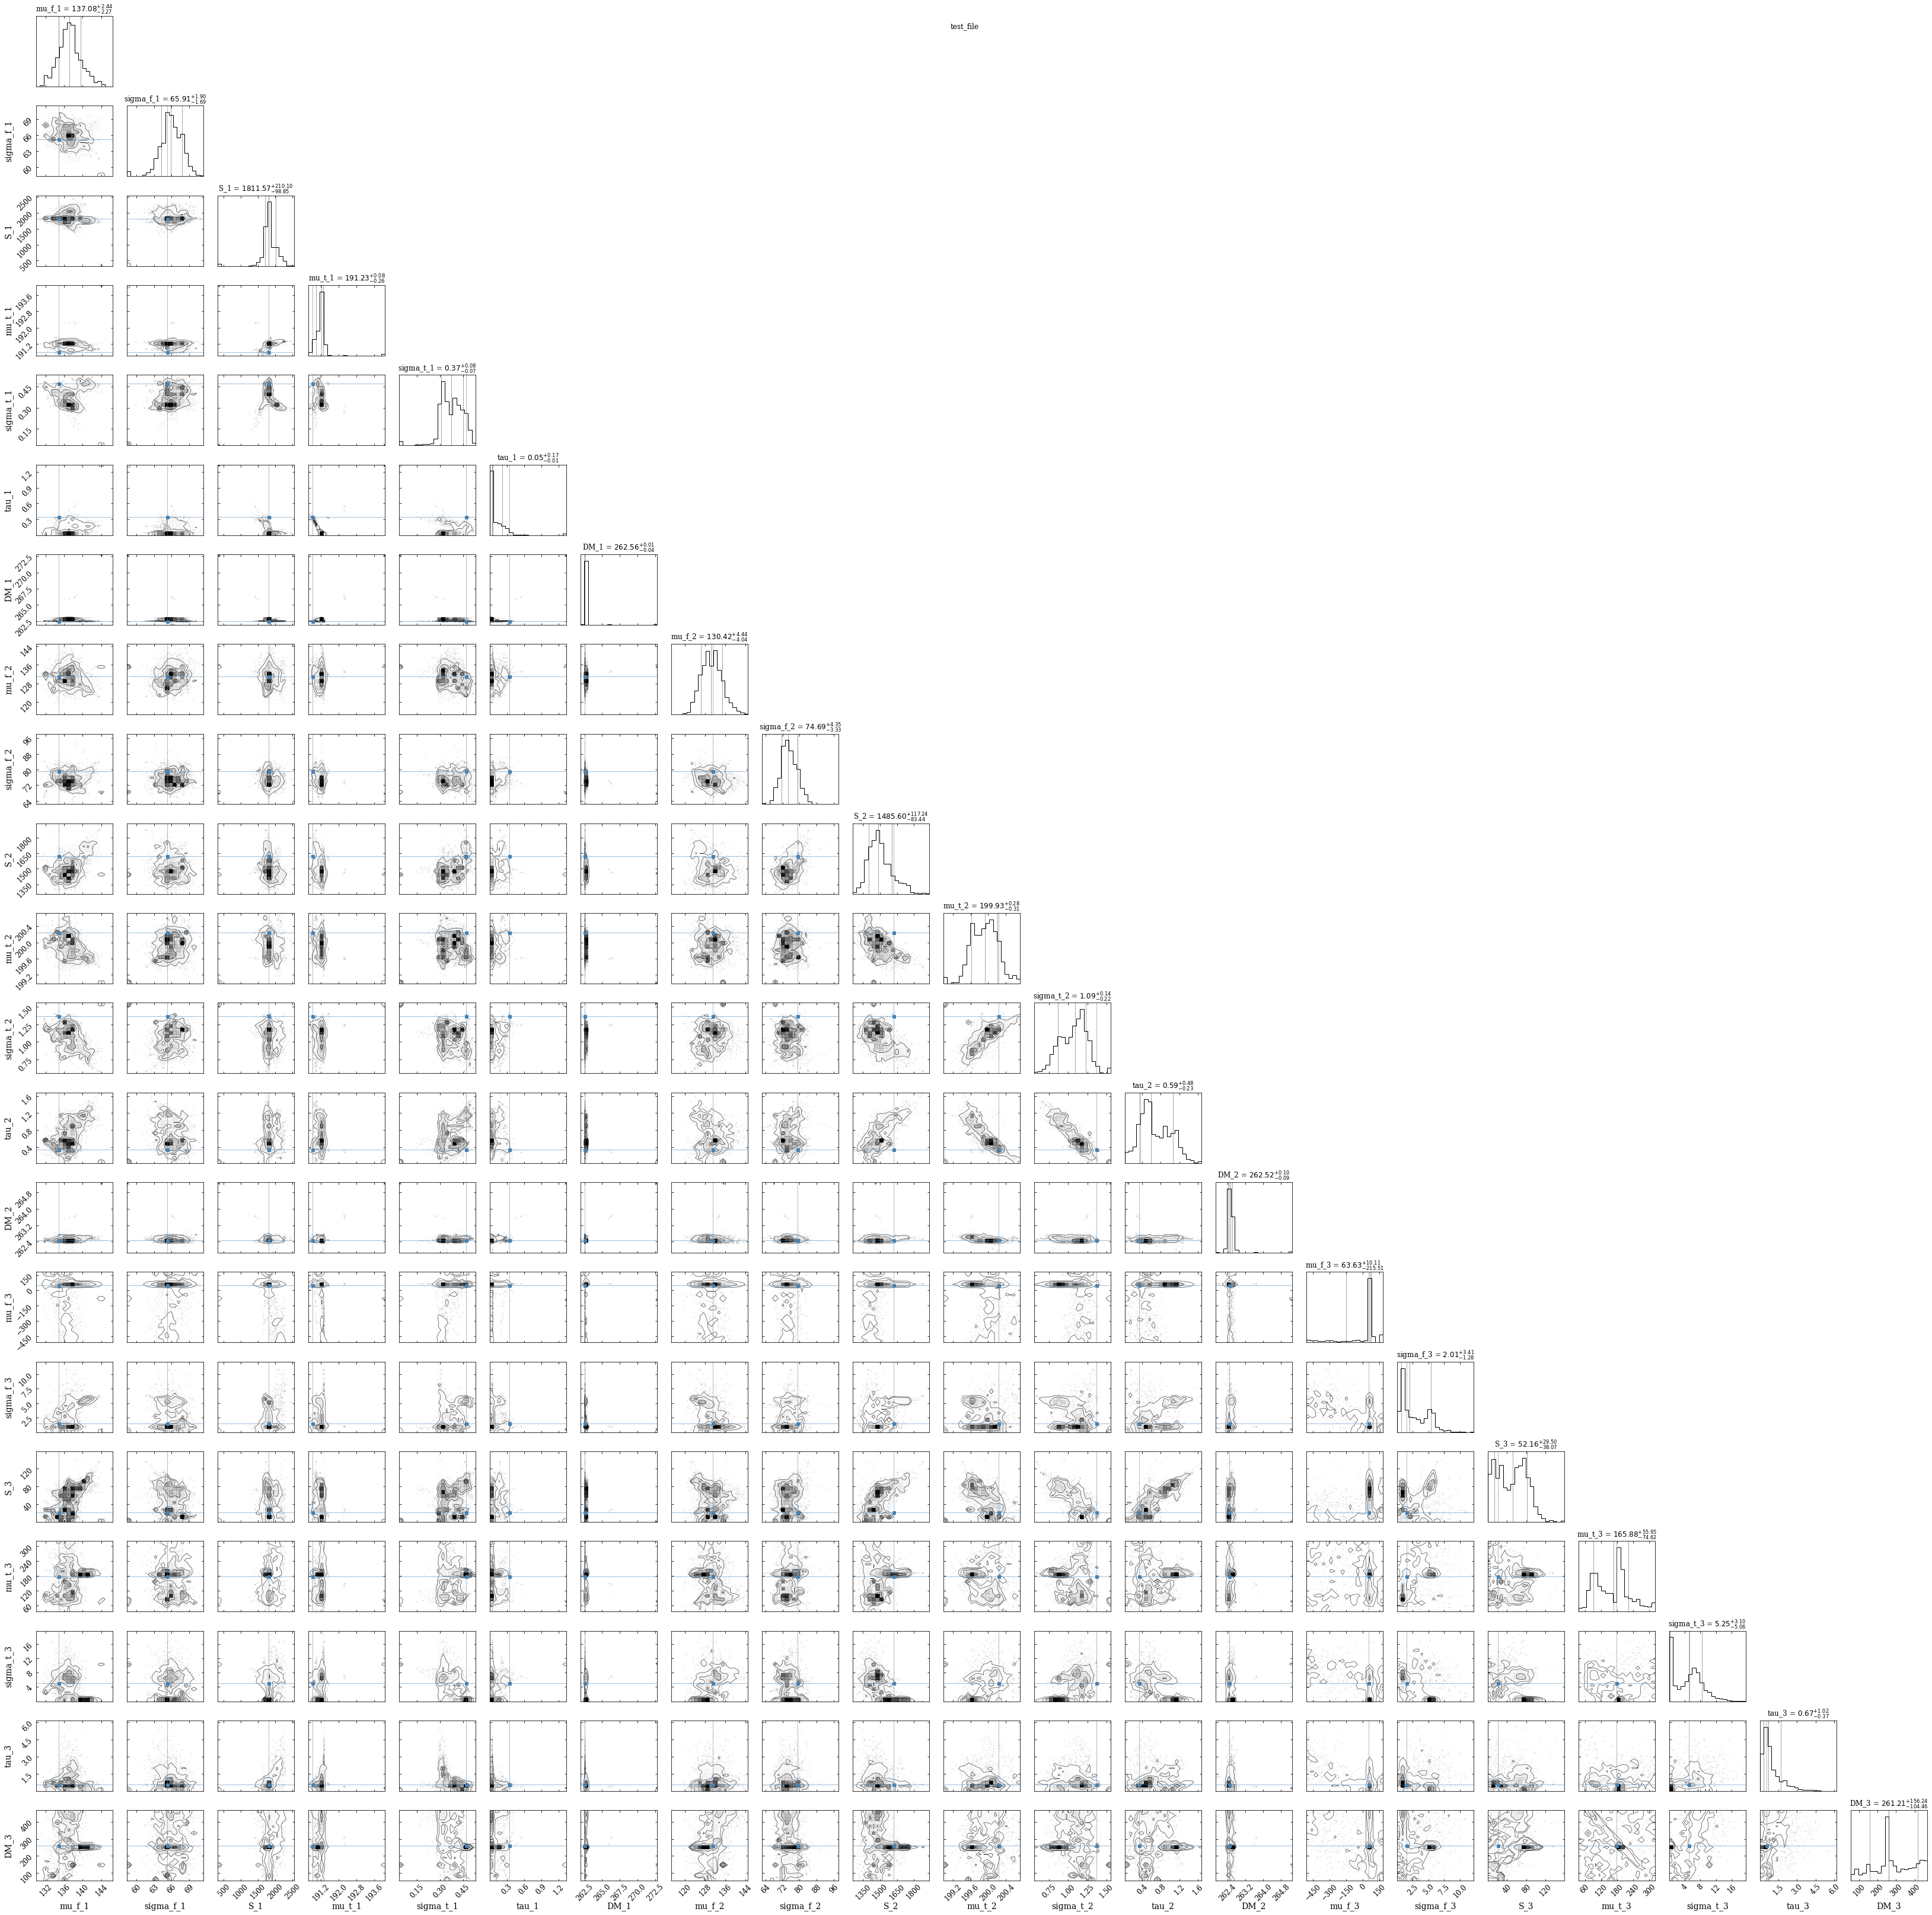

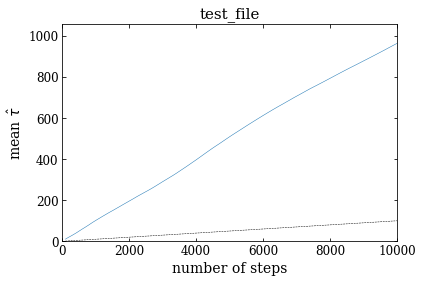

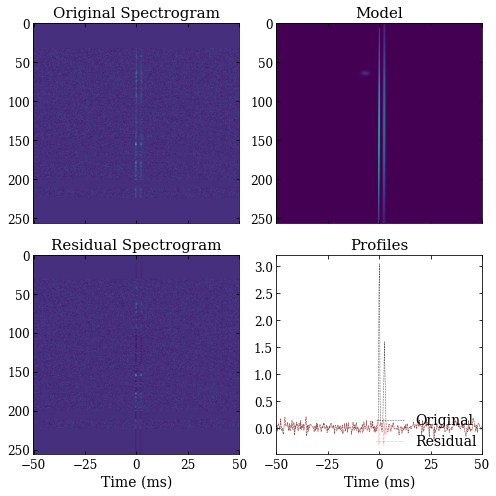

In [5]:
# MCMC 
# nwalker >= dimention + 1 
# nstep until getting smooth parameter distributions 
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':60, 'nsteps':int(1e4),
           'skip':500, 'ncores':4, 
           'start_pos_dev':0.01,
           'prior_range':0.8, 
           'save_results':True,
           'outname':'test_file'}

bf.run_mcmc(plot=True, **mcmc_kwargs)



In [ ]:
# save fitting results 
bd.prepare_data()
bio = BurstIO(bf, bd)
d = bio.save_results(outname=save_name+"_fit_results.json", outdir=save_dir)  
print(d['param_names'])

In [ ]:
# do not delete this cell. 
# fit again using the new DM result dm_fit
# data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, dm_fit, bd.width, nfreq_plot=nfreq, ndm=32)
# data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
# bf.sgram = data_burst
# bf.dm = dm_fit
# bd.dm = dm_fit 

# plt.plot(range(len(data_burst.mean(0))), data_burst.mean(0))
# plt.xlabel('Time Sample using new DM')

# bf.fitall(plot=False)
# plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
#                  bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res'+'_dm_burstfit', outdir=save_dir)


In [14]:
# saving key burst paramters 
mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc = bf.mcmc_params[1]['popt']
mu_f_mcmc_err, sigma_f_mcmc_err, s_mcmc_err, mu_t_mcmc_err, sigma_t_mcmc_err, tau_mcmc_err, dm_mcmc_err = bf.mcmc_params[1]['perr']

t0 = 0.45 + mu_t_mcmc * bd.tsamp
t0_err = [i * bd.tsamp for i in mu_t_mcmc_err] 

width_ms = sigma_t_mcmc * bd.tsamp * 1e3 # in ms
width_ms_err = [i * bd.tsamp for i in sigma_t_mcmc_err] 

# with open(save_dir+save_name+"_fit_key_results.txt") as f:
#     print('mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc')
#     print(bf.mcmc_params[1]['popt'])
#     print('lower, upper bounds')
#     print(bf.mcmc_params[1]['perr'])

#outname=save_name+"_fit_results.json", outdir=save_dir

In [15]:
rms_res = np.sqrt(sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0)))

rms_res = np.sqrt(sum(data.mean(0)**2) / len(data.mean(0)))

snr_mcmc = max(bf.model.mean(0)) / rms_res * np.sqrt(bf.width)

2022-01-24 18:12:09,946 - model -burstfit.fit - INFO - Making model.
2022-01-24 18:12:09,949 - model -burstfit.fit - INFO - Found 1 components.


In [18]:
data_mcmc_dm = ff.proc_cand_fil(fil_file, dm_mcmc, sigma_f_mcmc, nfreq_plot=nfreq, ndm=32)[0]

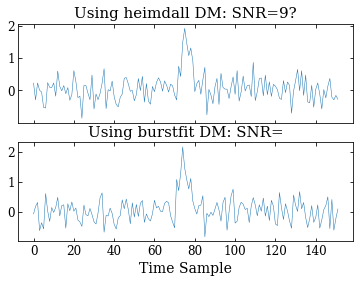

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(range(len(data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[0].set_title('Using heimdall DM: SNR=%d?'%bd.snr)

ax[1].plot(range(len(data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[1].set_xlabel('Time Sample')
ax[1].set_title('Using burstfit DM: SNR=')
fig.savefig(save_name + 'burst.pdf')

In [21]:
bf.mcmc_params

{1: {'popt': [4.708031244884689,
   1.85280016354413,
   90.85737756644824,
   187.8991723270993,
   0.9567291488430655,
   2.2145336012418158,
   314.0674867854782],
  'perr': [[0.24465106023286687, 0.24250744080276831],
   [0.2512486159717484, 0.3158300338000739],
   [12.792131298028593, 14.462276833939455],
   [1.0983315792561825, 1.2984426080577691],
   [0.5072899812359954, 0.6281460277956125],
   [0.7524568552423347, 0.6960233914243763],
   [0.7112840495276487, 0.6506028843043623]]}}

In [22]:
len(data_burst.mean(0))

382